## Importing Key Libraries

In [1]:
# Standard Packages #
import pandas as pd
import numpy as np
import pickle

# Visualisation Tools #
import matplotlib.pyplot as plt
import seaborn as sns

# Display Options #
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Loading and Checking Datasets

In [2]:
data = pd.DataFrame(pd.read_csv('./Data/train.csv', parse_dates=True, index_col='Date'))
stores = pd.DataFrame(pd.read_csv('./Data/store.csv'))

/home/joshua/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Checking for null data and feature types #
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [4]:
data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [5]:
# Dropping Customers as we do not know ex-ante what is the number of customers we have on a given day #
data.drop('Customers', axis=1, inplace=True)

In [6]:
# Checking why StateHoliday is an object #
data.StateHoliday.value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [7]:
# Changing the StateHoliday to a binary variable #
# Do not really need to differentiate between holidays as most stores will be closed #
data.StateHoliday = data.StateHoliday.apply(lambda x:
                                            0 if x == '0'
                                            else 1 if x == 'a'
                                            else 1 if x == 'b'
                                            else 1 if x == 'c'
                                            else 0)

In [8]:
# Checking the transformation #
data.StateHoliday.value_counts()

0    986159
1     31050
Name: StateHoliday, dtype: int64

In [9]:
# Checking if our index is properly classified as a datetime object #
data.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [10]:
# Creating additional time related features #
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Day'] = data.index.day
data['WeekOfYear'] = data.index.weekofyear

In [11]:
data.head()

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,
2015-07-31,1,5,5263,1,1,0,1,2015,7,31,31
2015-07-31,2,5,6064,1,1,0,1,2015,7,31,31
2015-07-31,3,5,8314,1,1,0,1,2015,7,31,31
2015-07-31,4,5,13995,1,1,0,1,2015,7,31,31
2015-07-31,5,5,4822,1,1,0,1,2015,7,31,31


### Investigating Entries with 0 Sales and Checking Store Closures

Checking for dates whereby the stores are open but have 0 sales.

In [12]:
data[data.Sales == 0].DayOfWeek.value_counts()

7    141137
4     11219
5      7212
1      7173
3      3743
2      1709
6       678
Name: DayOfWeek, dtype: int64

It appears most stores are closed on Sundays, therefore we will be dropping Sundays from our data.

In [13]:
# Dropping Sundays from our data #
data = data.loc[data.DayOfWeek != 7]

Checking for days that have 0 sales when the store is opened.

In [14]:
data[(data.Open == 1) & (data.Sales == 0)].head()

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,
2015-05-15,971,5,0,1,0,0,1,2015,5,15,20
2015-03-26,674,4,0,1,0,0,0,2015,3,26,13
2015-02-05,699,4,0,1,1,0,0,2015,2,5,6
2014-10-01,708,3,0,1,1,0,0,2014,10,1,40
2014-09-22,357,1,0,1,0,0,0,2014,9,22,39


In [15]:
data[(data.Open == 1) & (data.Sales == 0)].describe()

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
count,54.000000,54.000000,54.0,54.0,54.000000,54.0,54.000000,54.000000,54.000000,54.000000,54.000000
mean,582.592593,3.703704,0.0,1.0,0.388889,0.0,0.222222,2013.703704,5.277778,15.481481,21.388889
std,340.093190,1.312202,0.0,0.0,0.492076,0.0,0.419643,0.570654,2.817845,9.720123,11.784891
min,25.000000,1.000000,0.0,1.0,0.000000,0.0,0.000000,2013.000000,1.000000,1.000000,3.000000
25%,330.000000,3.000000,0.0,1.0,0.000000,0.0,0.000000,2013.000000,3.000000,7.000000,11.250000
50%,662.000000,4.000000,0.0,1.0,0.000000,0.0,0.000000,2014.000000,6.000000,14.000000,23.000000
75%,885.750000,4.000000,0.0,1.0,1.000000,0.0,0.000000,2014.000000,7.000000,24.000000,30.000000
max,1100.000000,6.000000,0.0,1.0,1.000000,0.0,1.000000,2015.000000,10.000000,31.000000,40.000000


There were 54 days in which around half of the stores were closed. As the number of days that are open and have 0 sales seem to be missing at random and the number of observations are small, we will be dropping these entries.

In [16]:
# Removing entries that are open but have no sales #
data = data[~((data.Open == 1) & (data.Sales == 0))]

Now let's investigate the entries when the store is closed on days that are not holidays. 

In [17]:
data[(data.Open == 0) & (data.StateHoliday == 0) & (data.SchoolHoliday == 0)].Store.value_counts().head(10)

1081    123
103     123
349      68
972      63
708      62
674      33
560      30
837      30
25       27
348      25
Name: Store, dtype: int64

In [18]:
data[(data.Open == 0) & (data.StateHoliday == 0) & (data.SchoolHoliday == 0)].Store.value_counts().describe()

count    143.000000
mean       9.944056
std       17.262177
min        1.000000
25%        3.000000
50%        4.000000
75%       11.000000
max      123.000000
Name: Store, dtype: float64

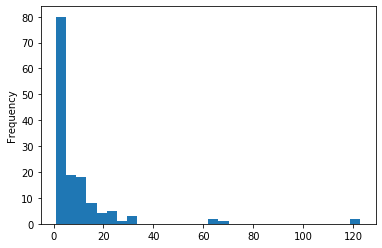

In [19]:
data[(data.Open == 0) & (data.StateHoliday == 0) & (data.SchoolHoliday == 0)].Store.value_counts().plot.hist(bins=30)

We can clearly see that there are 5 anomalous stores within our dataset, therefore, we will be removing these stores.

In [20]:
# Saving the anomalous stores to a list # 
anomalous_stores = data[(data.Open == 0) & (data.StateHoliday == 0) & (data.SchoolHoliday == 0)].Store.value_counts().head()
anomalous_stores_list = anomalous_stores.index.to_list()

In [21]:
# Dropping anomalous stores #
data = data[~data.Store.isin(anomalous_stores_list)]

In [22]:
# Creating a new column which schows if the date is a school or public holiday.
data['IsHoliday'] = np.nan
data.IsHoliday = np.where((data.StateHoliday == 1) | (data.SchoolHoliday == 1), 1, 0)

### The cleaning for the Sales dataset is done. Now let's take a look at the Stores dataset.

In [23]:
# Checking for datatypes and missing data #
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [24]:
stores.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [25]:
stores[stores.CompetitionDistance.isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [26]:
stores.CompetitionDistance.describe()

count     1112.000000
mean      5404.901079
std       7663.174720
min         20.000000
25%        717.500000
50%       2325.000000
75%       6882.500000
max      75860.000000
Name: CompetitionDistance, dtype: float64

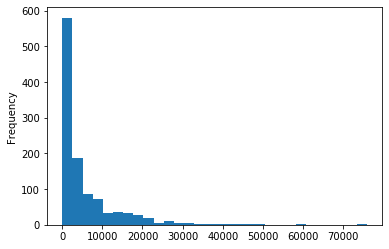

In [27]:
stores.CompetitionDistance.plot.hist(bins=30)

The missing competition distance seem to be missing at random. As we have a positive skewed distribution, we will be imputing the missing values with the median of the series. 

In [28]:
stores.CompetitionDistance.fillna(stores.CompetitionDistance.median(), inplace=True)

Checking the missing data for variables relating to competition open date.

In [29]:
stores[stores.CompetitionOpenSinceMonth.isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


Although there is no information for the opening month and year for the competition, there is still competition for the store. As we have no way of finding out the competition start date, we will be imputing the opening dates as the 1 month of the mean opening year of all stores. We will this will not affect the model training that much as the mean opening date is before the first entry in the training dataset.

In [30]:
stores.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1115.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5396.614350,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7654.513635,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,720.000000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6875.000000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [31]:
stores.CompetitionOpenSinceMonth.fillna(1, inplace=True)

In [32]:
stores.CompetitionOpenSinceYear.fillna(2008, inplace=True)

Investigating the missing data related to Promotion2.

In [33]:
stores[stores.Promo2 != 0].isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [34]:
stores[stores.Promo2 == 0].isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

It seems that the missing values from the promotions are due to the stores not participating in promotion 2. Therefore, we can fill these values with 0 as they naturally would not contain any information.

In [35]:
stores.fillna(0, inplace=True)

Now, we change some data types so that it is easier to work with.

In [36]:
stores.StoreType = stores.StoreType.apply(lambda x:
                                          1 if x == 'a'
                                          else 2 if x == 'b'
                                          else 3 if x == 'c'
                                          else 4)

In [37]:
stores.Assortment = stores.Assortment.apply(lambda x:
                                            1 if x == 'a'
                                            else 2 if x == 'b'
                                            else 3)

In [38]:
stores.PromoInterval = stores.PromoInterval.apply(lambda x:
                                                  1 if x == 'Jan,Apr,Jul,Oct'
                                                  else 2 if x == 'Feb,May,Aug,Nov'
                                                  else 3 if x == 'Mar,Jun,Sept,Dec'
                                                  else 0)

In [39]:
stores = stores.astype({"Promo2SinceWeek": int, "Promo2SinceYear": int})

In [40]:
stores = stores.astype({"CompetitionOpenSinceMonth": int,
                        "CompetitionOpenSinceYear": int})

In [41]:
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3,1,1270.0,9,2008,0,0,0,0
1,2,1,1,570.0,11,2007,1,13,2010,1
2,3,1,1,14130.0,12,2006,1,14,2011,1
3,4,3,3,620.0,9,2009,0,0,0,0
4,5,1,1,29910.0,4,2015,0,0,0,0


Creating logged variables for our continous variables as they help due with the positive skew present.

In [42]:
stores['LogCompetitionDistance'] = np.log(stores.CompetitionDistance)

In [43]:
stores.drop('CompetitionDistance', axis=1, inplace=True)

In [44]:
stores.shape

(1115, 10)

In [45]:
# Creating a new column for the different store type and assortment permutations #
stores.insert(10, "StorePermutation", 0)

In [46]:
def store_permutation(row):
    if row.StoreType == 1:
        if row.Assortment == 1:
            permutation = 1
    if row.StoreType == 1:
        if row.Assortment == 2:
            permutation = 2
    if row.StoreType == 1:
        if row.Assortment == 3:
            permutation = 3
    if row.StoreType == 2:
        if row.Assortment == 1:
            permutation = 4
    if row.StoreType == 2:
        if row.Assortment == 2:
            permutation = 5
    if row.StoreType == 2:
        if row.Assortment == 3:
            permutation = 6
    if row.StoreType == 3:
        if row.Assortment == 1:
            permutation = 7
    if row.StoreType == 3:
        if row.Assortment == 2:
            permutation = 8
    if row.StoreType == 3:
        if row.Assortment == 3:
            permutation = 9
    if row.StoreType == 4:
        if row.Assortment == 1:
            permutation = 10
    if row.StoreType == 4:
        if row.Assortment == 2:
            permutation = 11
    if row.StoreType == 4:
        if row.Assortment == 3:
            permutation = 12
    return permutation

In [47]:
stores.StorePermutation = stores.apply(store_permutation, axis=1)

In [48]:
stores.head()

,Store,StoreType,Assortment,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,LogCompetitionDistance,StorePermutation
0,1,3,1,9,2008,0,0,0,0,7.146772,7
1,2,1,1,11,2007,1,13,2010,1,6.345636,1
2,3,1,1,12,2006,1,14,2011,1,9.556055,1
3,4,3,3,9,2009,0,0,0,0,6.429719,9
4,5,1,1,4,2015,0,0,0,0,10.305948,1


### We have finished cleaning our two datasets and can now merge them into one dataset.

In [49]:
data_new = data.reset_index()

In [50]:
data_new.head()

,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,IsHoliday
0,2015-07-31,1,5,5263,1,1,0,1,2015,7,31,31,1
1,2015-07-31,2,5,6064,1,1,0,1,2015,7,31,31,1
2,2015-07-31,3,5,8314,1,1,0,1,2015,7,31,31,1
3,2015-07-31,4,5,13995,1,1,0,1,2015,7,31,31,1
4,2015-07-31,5,5,4822,1,1,0,1,2015,7,31,31,1


In [51]:
df = data_new.merge(stores, how='inner', on='Store')

In [52]:
df.head()

,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,IsHoliday,StoreType,Assortment,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,LogCompetitionDistance,StorePermutation
0,2015-07-31,1,5,5263,1,1,0,1,2015,7,31,31,1,3,1,9,2008,0,0,0,0,7.146772,7
1,2015-07-30,1,4,5020,1,1,0,1,2015,7,30,31,1,3,1,9,2008,0,0,0,0,7.146772,7
2,2015-07-29,1,3,4782,1,1,0,1,2015,7,29,31,1,3,1,9,2008,0,0,0,0,7.146772,7
3,2015-07-28,1,2,5011,1,1,0,1,2015,7,28,31,1,3,1,9,2008,0,0,0,0,7.146772,7
4,2015-07-27,1,1,6102,1,1,0,1,2015,7,27,31,1,3,1,9,2008,0,0,0,0,7.146772,7


### Doing some feature engineering.

In [53]:
df[df.Sales == 0].head(20)

,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,IsHoliday,StoreType,Assortment,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,LogCompetitionDistance,StorePermutation
49,2015-06-04,1,4,0,0,1,1,0,2015,6,4,23,1,3,1,9,2008,0,0,0,0,7.146772,7
58,2015-05-25,1,1,0,0,0,1,0,2015,5,25,22,1,3,1,9,2008,0,0,0,0,7.146772,7
67,2015-05-14,1,4,0,0,0,1,0,2015,5,14,20,1,3,1,9,2008,0,0,0,0,7.146772,7
78,2015-05-01,1,5,0,0,1,1,0,2015,5,1,18,1,3,1,9,2008,0,0,0,0,7.146772,7
100,2015-04-06,1,1,0,0,0,1,1,2015,4,6,15,1,3,1,9,2008,0,0,0,0,7.146772,7
102,2015-04-03,1,5,0,0,1,1,1,2015,4,3,14,1,3,1,9,2008,0,0,0,0,7.146772,7
181,2015-01-01,1,4,0,0,0,1,1,2015,1,1,1,1,3,1,9,2008,0,0,0,0,7.146772,7
186,2014-12-26,1,5,0,0,0,1,1,2014,12,26,52,1,3,1,9,2008,0,0,0,0,7.146772,7
187,2014-12-25,1,4,0,0,0,1,1,2014,12,25,52,1,3,1,9,2008,0,0,0,0,7.146772,7
258,2014-10-03,1,5,0,0,1,1,0,2014,10,3,40,1,3,1,9,2008,0,0,0,0,7.146772,7


As the days that have 0 Sales seem to be missing at random, we will just interpolate the missing sales data.

In [54]:
df.loc[df.Sales == 0, 'Sales'] = np.nan
df.Sales = df.Sales.interpolate()

In [55]:
# Creating a logged sales variable #
df['LogSales'] = np.log1p(df.Sales)

In [56]:
# Creating a new feature that counts how many months the competition has opened #
df['CompetitionTenureMonths'] = (12 * (df.Year - df.CompetitionOpenSinceYear)) + \
                                (df.Month - df.CompetitionOpenSinceMonth)

# Removes negative entries #
df.CompetitionTenureMonths = df.CompetitionTenureMonths.apply(lambda x:
                                                              x if x > 0
                                                              else 0)

In [57]:
df['LogCompetitionMonths'] = np.log1p(df.CompetitionTenureMonths)

In [58]:
# Creating a new feature that counts how many months promotion 2 has been ongoing #
df['Promo2Months'] = (12 * (df.Year - df.Promo2SinceYear) + \
                      ((df.WeekOfYear - df.Promo2SinceWeek) / 4))

# Removing negative entries #
df.Promo2Months = df.Promo2Months.apply(lambda x:
                                        x if x > 0
                                        else 0)

In [59]:
df.loc[(df.Promo2 == 0), 'Promo2Months'] = 0

In [60]:
df['LogPromo2Months'] = np.log1p(df.Promo2Months)

In [61]:
df.head()

,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,IsHoliday,StoreType,Assortment,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,LogCompetitionDistance,StorePermutation,LogSales,CompetitionTenureMonths,LogCompetitionMonths,Promo2Months,LogPromo2Months
0,2015-07-31,1,5,5263.0,1,1,0,1,2015,7,31,31,1,3,1,9,2008,0,0,0,0,7.146772,7,8.568646,82,4.418841,0.0,0.0
1,2015-07-30,1,4,5020.0,1,1,0,1,2015,7,30,31,1,3,1,9,2008,0,0,0,0,7.146772,7,8.521384,82,4.418841,0.0,0.0
2,2015-07-29,1,3,4782.0,1,1,0,1,2015,7,29,31,1,3,1,9,2008,0,0,0,0,7.146772,7,8.472823,82,4.418841,0.0,0.0
3,2015-07-28,1,2,5011.0,1,1,0,1,2015,7,28,31,1,3,1,9,2008,0,0,0,0,7.146772,7,8.519590,82,4.418841,0.0,0.0
4,2015-07-27,1,1,6102.0,1,1,0,1,2015,7,27,31,1,3,1,9,2008,0,0,0,0,7.146772,7,8.716536,82,4.418841,0.0,0.0


In [62]:
with open('data_without_time_vars.pickle', 'wb') as f:
    pickle.dump(df, f)

In [63]:
df_testing = df.set_index('Date').sort_index(ascending=True).reset_index()

In [64]:
store_groupby = df_testing.groupby('Store')

In [65]:
def making_lagged_features(df):
    df['Lagged1LogSales'] = df.LogSales.shift(1)
    df['Lagged2LogSales'] = df.LogSales.shift(2)
    df['Lagged3LogSales'] = df.LogSales.shift(3)
    df['Lagged4LogSales'] = df.LogSales.shift(4)
    df['Lagged5LogSales'] = df.LogSales.shift(5)
    df['Lagged6LogSales'] = df.LogSales.shift(6)
    df['Lagged7LogSales'] = df.LogSales.shift(7)
    df['Lagged8LogSales'] = df.LogSales.shift(8)
    df['Lagged9LogSales'] = df.LogSales.shift(9)
    df['Lagged10LogSales'] = df.LogSales.shift(10)
    df['Lagged11LogSales'] = df.LogSales.shift(11)
    df['Lagged12LogSales'] = df.LogSales.shift(12)
    
    return df

In [66]:
def avg_logsales_past_6days(row):
    mean = np.mean(row.Lagged1LogSales + row.Lagged2LogSales + row.Lagged3LogSales + \
                    row.Lagged4LogSales + row.Lagged5LogSales + row.Lagged6LogSales)
    
    return mean

In [67]:
def avg_logsales_past_12days(row):
    mean = np.mean(row.Lagged1LogSales + row.Lagged2LogSales + row.Lagged3LogSales + \
                    row.Lagged4LogSales + row.Lagged5LogSales + row.Lagged6LogSales + \
                    row.Lagged7LogSales + row.Lagged8LogSales + row.Lagged9LogSales + \
                    row.Lagged10LogSales + row.Lagged11LogSales + row.Lagged12LogSales)
    
    return mean

In [68]:
def logsales_stdev_past_6days(row):
    values = np.array([row.Lagged1LogSales, row.Lagged2LogSales, row.Lagged3LogSales,
                       row.Lagged4LogSales, row.Lagged5LogSales, row.Lagged6LogSales])
    
    stdev = np.std(values)
    
    return stdev

In [69]:
def logsales_stdev_past_12days(row):
    values = np.array([row.Lagged1LogSales, row.Lagged2LogSales, row.Lagged3LogSales,
                       row.Lagged4LogSales, row.Lagged5LogSales, row.Lagged6LogSales,
                       row.Lagged7LogSales, row.Lagged8LogSales, row.Lagged9LogSales,
                       row.Lagged10LogSales, row.Lagged11LogSales, row.Lagged12LogSales])
    
    stdev = np.std(values)
    
    return stdev

In [70]:
def max_logsales_past_6days(row):
    values = np.array([row.Lagged1LogSales, row.Lagged2LogSales, row.Lagged3LogSales,
                       row.Lagged4LogSales, row.Lagged5LogSales, row.Lagged6LogSales])
    
    max_value = values.max()
    
    return max_value

In [71]:
def max_logsales_past_12days(row):
    values = np.array([row.Lagged1LogSales, row.Lagged2LogSales, row.Lagged3LogSales,
                       row.Lagged4LogSales, row.Lagged5LogSales, row.Lagged6LogSales,
                       row.Lagged7LogSales, row.Lagged8LogSales, row.Lagged9LogSales,
                       row.Lagged10LogSales, row.Lagged11LogSales, row.Lagged12LogSales])

    max_value = values.max()
    
    return max_value

In [72]:
def min_logsales_past_6days(row):
    values = np.array([row.Lagged1LogSales, row.Lagged2LogSales, row.Lagged3LogSales,
                       row.Lagged4LogSales, row.Lagged5LogSales, row.Lagged6LogSales])
    
    min_value = values[values != 0].min()
    
    return min_value

In [73]:
def min_logsales_past_12days(row):
    values = np.array([row.Lagged1LogSales, row.Lagged2LogSales, row.Lagged3LogSales,
                       row.Lagged4LogSales, row.Lagged5LogSales, row.Lagged6LogSales,
                       row.Lagged7LogSales, row.Lagged8LogSales, row.Lagged9LogSales,
                       row.Lagged10LogSales, row.Lagged11LogSales, row.Lagged12LogSales])

    min_value = values[values != 0].min()
    
    return min_value

In [74]:
def making_window_features(df):
    df['Past6daysAvgLogSales'] = df.apply(avg_logsales_past_6days, axis=1)
    df['Past12DaysAvgLogSales'] = df.apply(avg_logsales_past_12days, axis=1)
    df['Past6DaysLogSalesSTDEV'] = df.apply(logsales_stdev_past_6days, axis=1)
    df['Past12DaysLogSalesSTDEV'] = df.apply(logsales_stdev_past_12days, axis=1)
    df['Past6DaysMaxLogSales'] = df.apply(max_logsales_past_6days, axis=1)
    df['Past12DaysMaxLogSales'] = df.apply(max_logsales_past_12days, axis=1)
    df['Past6DaysMinLogSales'] = df.apply(min_logsales_past_6days, axis=1)
    df['Past12DaysMinLogSales'] = df.apply(min_logsales_past_12days, axis=1)
    
    return df

In [75]:
df_enhanced = pd.DataFrame()

counter = 0
for store, group in store_groupby:
    print(f'Current counter: {counter}')
        
    group = making_lagged_features(group)
    group = making_window_features(group)
    
    df_enhanced = df_enhanced.append(group)
    counter += 1

Current counter: 0


/home/joshua/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/joshua/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/joshua/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Current counter: 1
Current counter: 2
Current counter: 3
Current counter: 4
Current counter: 5
Current counter: 6
Current counter: 7
Current counter: 8
Current counter: 9
Current counter: 10
Current counter: 11
Current counter: 12
Current counter: 13
Current counter: 14
Current counter: 15
Current counter: 16
Current counter: 17
Current counter: 18
Current counter: 19
Current counter: 20
Current counter: 21
Current counter: 22
Current counter: 23
Current counter: 24
Current counter: 25
Current counter: 26
Current counter: 27
Current counter: 28
Current counter: 29
Current counter: 30
Current counter: 31
Current counter: 32
Current counter: 33
Current counter: 34
Current counter: 35
Current counter: 36
Current counter: 37
Current counter: 38
Current counter: 39
Current counter: 40
Current counter: 41
Current counter: 42
Current counter: 43
Current counter: 44
Current counter: 45
Current counter: 46
Current counter: 47
Current counter: 48
Current counter: 49
Current counter: 50
Current c

Current counter: 397
Current counter: 398
Current counter: 399
Current counter: 400
Current counter: 401
Current counter: 402
Current counter: 403
Current counter: 404
Current counter: 405
Current counter: 406
Current counter: 407
Current counter: 408
Current counter: 409
Current counter: 410
Current counter: 411
Current counter: 412
Current counter: 413
Current counter: 414
Current counter: 415
Current counter: 416
Current counter: 417
Current counter: 418
Current counter: 419
Current counter: 420
Current counter: 421
Current counter: 422
Current counter: 423
Current counter: 424
Current counter: 425
Current counter: 426
Current counter: 427
Current counter: 428
Current counter: 429
Current counter: 430
Current counter: 431
Current counter: 432
Current counter: 433
Current counter: 434
Current counter: 435
Current counter: 436
Current counter: 437
Current counter: 438
Current counter: 439
Current counter: 440
Current counter: 441
Current counter: 442
Current counter: 443
Current count

Current counter: 788
Current counter: 789
Current counter: 790
Current counter: 791
Current counter: 792
Current counter: 793
Current counter: 794
Current counter: 795
Current counter: 796
Current counter: 797
Current counter: 798
Current counter: 799
Current counter: 800
Current counter: 801
Current counter: 802
Current counter: 803
Current counter: 804
Current counter: 805
Current counter: 806
Current counter: 807
Current counter: 808
Current counter: 809
Current counter: 810
Current counter: 811
Current counter: 812
Current counter: 813
Current counter: 814
Current counter: 815
Current counter: 816
Current counter: 817
Current counter: 818
Current counter: 819
Current counter: 820
Current counter: 821
Current counter: 822
Current counter: 823
Current counter: 824
Current counter: 825
Current counter: 826
Current counter: 827
Current counter: 828
Current counter: 829
Current counter: 830
Current counter: 831
Current counter: 832
Current counter: 833
Current counter: 834
Current count

In [76]:
df_enhanced = df_enhanced.reset_index(drop=True)

In [77]:
with open('data_with_feature_engineering.pickle', 'wb') as f:
    pickle.dump(df_enhanced,f)

In [78]:
df_enhanced.iloc[780:850]

,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,IsHoliday,StoreType,Assortment,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,LogCompetitionDistance,StorePermutation,LogSales,CompetitionTenureMonths,LogCompetitionMonths,Promo2Months,LogPromo2Months,Lagged1LogSales,Lagged2LogSales,Lagged3LogSales,Lagged4LogSales,Lagged5LogSales,Lagged6LogSales,Lagged7LogSales,Lagged8LogSales,Lagged9LogSales,Lagged10LogSales,Lagged11LogSales,Lagged12LogSales,Past6daysAvgLogSales,Past12DaysAvgLogSales,Past6DaysLogSalesSTDEV,Past12DaysLogSalesSTDEV,Past6DaysMaxLogSales,Past12DaysMaxLogSales,Past6DaysMinLogSales,Past12DaysMinLogSales
780,2015-06-30,1,2,5735.0,1,1,0,0,2015,6,30,27,0,3,1,9,2008,0,0,0,0,7.146772,7,8.654517,81,4.406719,0.00,0.000000,8.556029,8.299037,8.107117,8.170186,8.115820,8.232972,8.255049,8.318254,8.343554,8.443762,8.294300,8.487352,49.481161,99.623432,0.153340,0.134793,8.556029,8.556029,8.107117,8.107117
781,2015-07-01,1,3,5223.0,1,1,0,0,2015,7,1,27,0,3,1,9,2008,0,0,0,0,7.146772,7,8.561019,82,4.418841,0.00,0.000000,8.654517,8.556029,8.299037,8.107117,8.170186,8.115820,8.232972,8.255049,8.318254,8.343554,8.443762,8.294300,49.902707,99.790597,0.215040,0.159590,8.654517,8.654517,8.107117,8.107117
782,2015-07-02,1,4,5558.0,1,1,0,0,2015,7,2,27,0,3,1,9,2008,0,0,0,0,7.146772,7,8.623174,82,4.418841,0.00,0.000000,8.561019,8.654517,8.556029,8.299037,8.107117,8.170186,8.115820,8.232972,8.255049,8.318254,8.343554,8.443762,50.347906,100.057316,0.209518,0.173043,8.654517,8.654517,8.107117,8.107117
783,2015-07-03,1,5,4665.0,1,1,0,0,2015,7,3,27,0,3,1,9,2008,0,0,0,0,7.146772,7,8.448057,82,4.418841,0.00,0.000000,8.623174,8.561019,8.654517,8.556029,8.299037,8.107117,8.170186,8.115820,8.232972,8.255049,8.318254,8.343554,50.800893,100.236728,0.197503,0.188579,8.654517,8.654517,8.107117,8.107117
784,2015-07-04,1,6,4797.0,1,0,0,0,2015,7,4,27,0,3,1,9,2008,0,0,0,0,7.146772,7,8.475954,82,4.418841,0.00,0.000000,8.448057,8.623174,8.561019,8.654517,8.556029,8.299037,8.107117,8.170186,8.115820,8.232972,8.255049,8.318254,51.141833,100.341231,0.119472,0.190343,8.654517,8.654517,8.299037,8.107117
785,2015-07-06,1,1,4359.0,1,0,0,0,2015,7,6,28,0,3,1,9,2008,0,0,0,0,7.146772,7,8.380227,82,4.418841,0.00,0.000000,8.475954,8.448057,8.623174,8.561019,8.654517,8.556029,8.299037,8.107117,8.170186,8.115820,8.232972,8.255049,51.318751,100.498931,0.073317,0.192319,8.654517,8.654517,8.448057,8.107117
786,2015-07-07,1,2,3650.0,1,0,0,0,2015,7,7,28,0,3,1,9,2008,0,0,0,0,7.146772,7,8.202756,82,4.418841,0.00,0.000000,8.380227,8.475954,8.448057,8.623174,8.561019,8.654517,8.556029,8.299037,8.107117,8.170186,8.115820,8.232972,51.142949,100.624110,0.097456,0.188899,8.654517,8.654517,8.380227,8.107117
787,2015-07-08,1,3,3797.0,1,0,0,0,2015,7,8,28,0,3,1,9,2008,0,0,0,0,7.146772,7,8.242230,82,4.418841,0.00,0.000000,8.202756,8.380227,8.475954,8.448057,8.623174,8.561019,8.654517,8.556029,8.299037,8.107117,8.170186,8.115820,50.691188,100.593894,0.134769,0.191102,8.623174,8.654517,8.202756,8.107117
788,2015-07-09,1,4,3897.0,1,0,0,0,2015,7,9,28,0,3,1,9,2008,0,0,0,0,7.146772,7,8.268219,82,4.418841,0.00,0.000000,8.242230,8.202756,8.380227,8.475954,8.448057,8.623174,8.561019,8.654517,8.556029,8.299037,8.107117,8.170186,50.372399,100.720305,0.142563,0.179207,8.623174,8.654517,8.202756,8.107117
789,2015-07-10,1,5,3808.0,1,0,0,0,2015,7,10,28,0,3,1,9,2008,0,0,0,0,7.146772,7,8.245122,82,4.418841,0.00,0.000000,8.268219,8.242230,8.202756,8.380227,8.475954,8.448057,8.623174,8.561019,8.654517,8.556029,8.299037,8.107117,50.017444,100.818338,0.104276,0.170889,8.475954,8.654517,8.202756,8.107117
